In [3]:
!pip install gdown
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/dataset/data_2024-10-01.parquet'

columns = ['page_view_order_number', 'randPAS_user_agent_id', 'randPAS_session_id','ua_is_bot']

try:
    df = pd.read_parquet(file_path, columns = columns)
    print(f"Файл {file_path} успешно прочитан!")
    print("\nПервые 5 строк данных:")
    print(df.head())
except Exception as e:
    print(f"Ошибка при чтении файла: {e}")

Файл /content/drive/MyDrive/dataset/data_2024-10-01.parquet успешно прочитан!

Первые 5 строк данных:
   page_view_order_number                   randPAS_user_agent_id  \
0                       1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
1                       1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
2                       1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
3                       1  \g!R|]g5n4v5ran]'9X=]\PW<e_\T iM0FK8;o   
4                       1  `/g9`X*'MPj_JMQa#b2?],clayli;|BlaPZj"j   

                           randPAS_session_id  ua_is_bot  
0  4%XDie;J=kgs0/~wXc+{8e,9UF<D5^Eq'}s;m!nsUi        NaN  
1  4%XDie;J=kgs0/~wXc+{8e,9UF<D5^Eq'}s;m!nsUi        NaN  
2  4%XDie;J=kgs0/~wXc+{8e,9UF<D5^Eq'}s;m!nsUi        NaN  
3  UYQTIra=#IHtS;IE6h)(K^giZsDO%rd$CGECQ"0kK<        NaN  
4  b7:/-xcsHQ[xz=1q|^Wxn:+W#OewS7hw8l=O%/6BD>        NaN  


In [6]:
# Фильтрация:  не 1
df_new = df[(df['ua_is_bot'] != 1)]
print(df_new)

          page_view_order_number                   randPAS_user_agent_id  \
0                              1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
1                              1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
2                              1  BMGo7*{(%<mrB%:<:`vyykg<sf,f<}qM6;+Iq4   
3                              1  \g!R|]g5n4v5ran]'9X=]\PW<e_\T iM0FK8;o   
4                              1  `/g9`X*'MPj_JMQa#b2?],clayli;|BlaPZj"j   
...                          ...                                     ...   
12692788                      43  eY72r9^5WS'>MkwceBtdiJ&3&9 0_XGT4=sDyv   
12692789                       3  oQpS1&)rh_o=;eQ%G^|sGSP.,BD{LefKE~FX@e   
12692790                       2  %T.,!D*NN+*{UJakm5C}G7+Gl x;2qT;F]0B!~   
12692791                      20  Fsmv~pw[y{na?W|k{N4AG%Q{_6}F" |+_*l1wa   
12692792                       8  AJN%u##`/Ek&CbP`U%DuKG 2n7n;/g"}kGB:Bb   

                                  randPAS_session_id  ua_is_bot  
0         4%XDie;J=kg

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12486800 entries, 0 to 12692792
Data columns (total 4 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   page_view_order_number  uint32 
 1   randPAS_user_agent_id   object 
 2   randPAS_session_id      object 
 3   ua_is_bot               float64
dtypes: float64(1), object(2), uint32(1)
memory usage: 428.7+ MB


In [9]:
def detect_page_number_anomalies(
    df,
    user_id_column='randPAS_user_agent_id',
    session_id_column='randPAS_session_id'
):
    """
    Находит аномалии в нумерации page_view_order_number:
    - reset: текущий номер < предыдущего (например, 3 → 1),
    - skip: текущий номер > предыдущего + 1 (например, 2 → 4),
    - duplicate: текущий номер == предыдущему (например, 2 → 2).
    """

    # Создание пустого списка для хранения найденных аномалий
    anomalies = []

    # Группировка данных по комбинации user_id и session_id:
    # df.groupby() создает итератор по группам
    # Каждая группа содержит записи для одного пользователя в одной сессии


    # Извлечение значений номеров просмотров страниц для текущей группы (пользователь+сессия)
    for (user_id, session_id), group in df.groupby([user_id_column, session_id_column]):
        page_numbers = group['page_view_order_number'].values

        # Цикл по номерам просмотров (начиная со второго элемента)
        for i in range(1, len(page_numbers)):
            prev_num = page_numbers[i-1] # Получение предыдущего и текущего номеров просмотра
            current_num = page_numbers[i]

            # Проверка на сброс нумерации (reset): если текущий номер меньше предыдущего - добавляем запись об аномалии в список
            if current_num < prev_num:
                anomalies.append({
                    'user_id': user_id,
                    'session_id': session_id,
                    'event_index': i,
                    'page_view_order_number': current_num,
                    'previous_number': prev_num,
                    'anomaly_type': 'reset'
                })

            # Проверка на дублирование (duplicate): если текущий номер равен предыдущему - добавляем запись об аномалии
            elif current_num == prev_num:
                anomalies.append({
                    'user_id': user_id,
                    'session_id': session_id,
                    'event_index': i,
                    'page_view_order_number': current_num,
                    'previous_number': prev_num,
                    'anomaly_type': 'duplicate'
                })

            # Проверка на пропуск (skip): если разница между текущим и предыдущим номером > 1 - добавляем запись об аномалии
            elif current_num - prev_num > 1:
                anomalies.append({
                    'user_id': user_id,
                    'session_id': session_id,
                    'event_index': i,
                    'page_view_order_number': current_num,
                    'previous_number': prev_num,
                    'anomaly_type': 'skip'
                })
    # Преобразование списка аномалий в DataFrame и возврат результата
    return pd.DataFrame(anomalies)

anomalies_df = detect_page_number_anomalies(df_new)

In [10]:
print(anomalies_df.head(5))

                                  user_id  \
0     +y.eYW:y]^B@p)u}a/^dnt(<eDmm>.`1P%H   
1     +y.eYW:y]^B@p)u}a/^dnt(<eDmm>.`1P%H   
2     +y.eYW:y]^B@p)u}a/^dnt(<eDmm>.`1P%H   
3     +y.eYW:y]^B@p)u}a/^dnt(<eDmm>.`1P%H   
4     +y.eYW:y]^B@p)u}a/^dnt(<eDmm>.`1P%H   

                                   session_id  event_index  \
0  4z6x8$}JOE&>~`U:qo;%spYLp7sBakI,Fp`aISr!22            1   
1  4z6x8$}JOE&>~`U:qo;%spYLp7sBakI,Fp`aISr!22            2   
2  4z6x8$}JOE&>~`U:qo;%spYLp7sBakI,Fp`aISr!22            3   
3  4z6x8$}JOE&>~`U:qo;%spYLp7sBakI,Fp`aISr!22            4   
4  4z6x8$}JOE&>~`U:qo;%spYLp7sBakI,Fp`aISr!22            5   

   page_view_order_number  previous_number anomaly_type  
0                       3                3    duplicate  
1                       3                3    duplicate  
2                       3                3    duplicate  
3                       3                3    duplicate  
4                       3                3    duplicate  


In [16]:

a=detect_page_number_anomalies(df)
print(f'без учета ботов: {len(a)}')
print(f'c учетом {len(anomalies_df)}')

без учета ботов: 9820720
c учетом 9616651


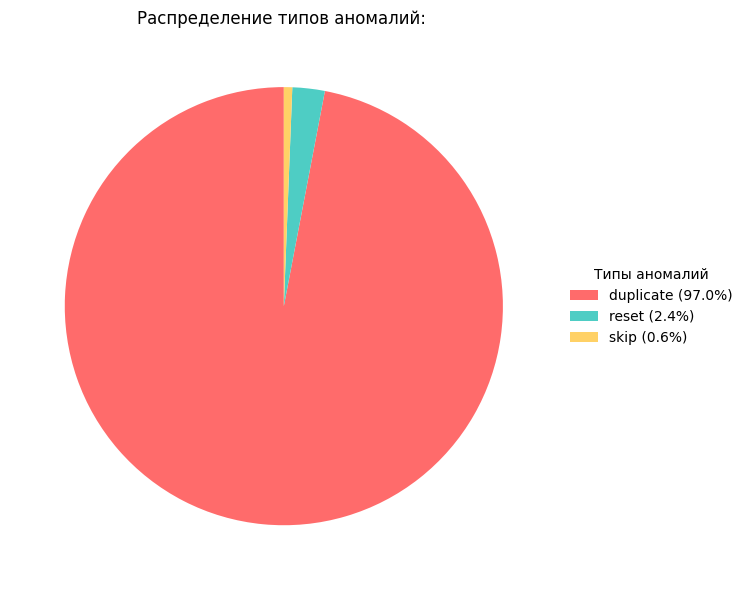

In [13]:
# Считаем количество каждого типа аномалий
anomaly_counts = anomalies_df["anomaly_type"].value_counts()
total = sum(anomaly_counts)
percentages = [f'{(count/total)*100:.1f}%' for count in anomaly_counts]

# Создаем подписи для легенды (название + процент)
legend_labels = [f"{label} ({pct})" for label, pct in zip(anomaly_counts.index, percentages)]

# Рисуем круговую диаграмму
plt.figure(figsize=(8, 6))
patches = plt.pie(
    anomaly_counts,
    labels=None,  # Полностью убираем все подписи на диаграмме
    colors=["#FF6B6B", "#4ECDC4", "#FFD166"],
    startangle=90,
    pctdistance=0.8  # Отодвигаем проценты (если оставим autopct)
)[0]  # Берем только патчи (сектора диаграммы)

plt.title("Распределение типов аномалий: ")

# Добавляем легенду с процентами
plt.legend(
    patches,
    legend_labels,  # Используем наши составные подписи
    title="Типы аномалий",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

# Убираем процентные подписи с самой диаграммы (если они есть)
plt.gca().set_autoscale_on(False)

plt.tight_layout()
plt.show()

In [14]:
from IPython.display import display

# Выбираем случайные 5 аномалий
sample_anomalies = anomalies_df.sample(5, random_state=42)

# Красивое отображение
display(
    sample_anomalies[
        ["user_id", "session_id", "event_index", "previous_number", "page_view_order_number", "anomaly_type"]
    ].style.set_caption("Примеры аномалий")
)

,user_id,session_id,event_index,previous_number,page_view_order_number,anomaly_type
1436745,"/0-\A,$1 odA%W3\)*+Ngzl';~?A(:85x=rh;l","h4/6qA""hy>8INQMP)R<>Xgz""kWnb lwL3LB",6,2,2,duplicate
2550718,"6Jt$xX=uNBl_Xo""[C+o*6@ueY\|G%Q!Lu:^mxs",{'~Gb6qkb%cFAEXmLgmYphp=.K6ey/Bm+6ZX<(K/N:,6,2,2,duplicate
8562647,"s]76-qtB%jjcJ:6[):fNl! },>(PK1] \a"" `U",Q#FMCy$j=VqDn`|=(?22fCsdod_cDvz/G{>ZS@}_b&,3,1,1,duplicate
9230262,"zl`]UGQZk)M[ugn%DWuX; #/H4I9/7EP=Gn,8R","@TCJ2%""9VLK+[Qws{lvVyY<}&'aOrF)#c~pOf1Jb0k",22,2,2,duplicate
2814670,9@Ne(c9-`F:&61 t*t)mbDu;hh/'E9KQ;odr[>,L4NjIpUkaV4%O+M%v\:O52Q&e'OEv1Fcu7V_Xk53xy,4,2,2,duplicate
